
# Crypto LSTM with Asset Embeddings (TensorFlow)

This notebook builds a full pipeline to train a stacked LSTM with **asset embeddings** on your wide table of hourly data:
- `time`
- `<ASSET>_price` and `<ASSET>_volume` for each asset (e.g., `BTC_price`, `BTC_volume`, ...)

You can drop your wide DataFrame in as `df_wide` and run end-to-end.

> Generated: 2025-09-03T02:56:41Z


In [71]:

# --- Setup & Config ---
import numpy as np
import pandas as pd
from typing import List, Dict
from pathlib import Path

import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.saving import save_model
from config import LOOKBACK_L, HORIZON_H, TEST_SAMPLES, FEATURES, TARGET, ASSUME_TZ

print("TF version:", tf.__version__)

TF version: 2.18.0


In [72]:
print(f"""
📊 Model Configuration
────────────────────────────
LOOKBACK_L : {LOOKBACK_L}
HORIZON_H  : {HORIZON_H}
TEST_SAMPLES: {TEST_SAMPLES}
FEATURES    : {FEATURES}
TARGET      : {TARGET}
ASSUME_TZ   : {ASSUME_TZ}
────────────────────────────
""")


📊 Model Configuration
────────────────────────────
LOOKBACK_L : 96
HORIZON_H  : 3
TEST_SAMPLES: 2000
FEATURES    : ['price_pct_change', 'volume_pct_change']
TARGET      : target_pct_chage
ASSUME_TZ   : None
────────────────────────────




## Load your data (`df_wide`) & drop empty assets

Expected format: wide DataFrame with
- `time`
- `<ASSET>_price`, `<ASSET>_volume`

We will **drop any asset** whose `_price` and `_volume` columns are entirely NaN **before** reshaping.
If `df_wide` is not defined, we create a small toy dataset.


In [73]:
df_wide = pd.read_csv("crypto_market_dataset.csv", dtype={"time": "string"})

# Best: ISO8601 parser (handles 'T', fractional seconds, and 'Z')
df_wide["time"] = pd.to_datetime(df_wide["time"], format="ISO8601", utc=True)

# --- Normalize column names: rename *_close -> *_price ---
rename_map = {}
for col in df_wide.columns:
    if col.endswith("_close"):
        asset = col.rsplit("_", 1)[0]   # everything before "_close"
        rename_map[col] = f"{asset}_price"

if rename_map:
    df_wide = df_wide.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

In [74]:
def find_majority_window(df_wide, min_frac=0.8):
    """
    Given df_wide with columns:
        - 'time'
        - <ASSET>_price, <ASSET>_volume
    Returns the largest contiguous [start, end] where
    at least `min_frac` of assets have data at each timestamp.
    """
    df = df_wide.copy()
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Identify asset prefixes
    assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

    # Count how many assets are non-NaN at each timestamp (price only)
    price_cols = [f"{a}_price" for a in assets if f"{a}_price" in df.columns]
    df['available'] = df[price_cols].notna().sum(axis=1)

    # Fraction of available assets at each time
    df['coverage'] = df['available'] / len(price_cols)

    # Mask where coverage >= threshold
    mask = df['coverage'] >= min_frac

    # Find contiguous runs of True
    df['block'] = (mask != mask.shift()).cumsum()
    runs = (
        df.loc[mask]
          .groupby('block')
          .agg(start=('time','min'), end=('time','max'), length=('time','count'))
    )

    if runs.empty:
        raise RuntimeError("No window satisfies coverage threshold.")

    # Pick the longest run
    best = runs.loc[runs['length'].idxmax()]
    return best['start'], best['end'], runs

In [76]:
start, end, runs = find_majority_window(df_wide, min_frac=0.6)
print("Best window:", start, "→", end, f"(length {runs['length'].max()} rows)")

Best window: 2024-03-21 12:00:00+00:00 → 2025-09-03 15:00:00+00:00 (length 12658 rows)


In [77]:
df_cut = df_wide[(df_wide["time"] >= start) & (df_wide["time"] <= end)].copy()

print("Original shape:", df_wide.shape)
print("Trimmed shape:", df_cut.shape)
print("Window:", start, "→", end)

Original shape: (92559, 55)
Trimmed shape: (12658, 55)
Window: 2024-03-21 12:00:00+00:00 → 2025-09-03 15:00:00+00:00


In [78]:
df_test_data = df_wide[(df_wide["time"] < start)].copy()
eth_data = pd.DataFrame()
eth_data["time"] = df_test_data["time"].values
eth_data["ETH_price"] = df_test_data["ETH_price"].values
eth_data["ETH_volume"] = df_test_data["ETH_volume"].values

eth_data.to_csv("./paper_wallet_data/eth_data.csv")

In [79]:
# --- Drop sparse assets (<90% non-NaN in price or volume) ---
threshold = 0.9
n_rows = len(df_cut)

asset_prefixes = {c.split("_")[0] for c in df_cut.columns if "_" in c and c != "time"}
drop_cols = []
dropped_assets = []

for a in sorted(asset_prefixes):
    p, v = f"{a}_price", f"{a}_volume"
    if p in df_cut.columns and v in df_cut.columns:
        frac_price  = df_cut[p].notna().mean()
        frac_volume = df_cut[v].notna().mean()
        if (frac_price < threshold) or (frac_volume < threshold):
            drop_cols += [p, v]
            dropped_assets.append((a, frac_price, frac_volume))

if drop_cols:
    df_cut = df_cut.drop(columns=drop_cols)
    print("Dropped sparse assets (name, price%, volume%):")
    for a, fp, fv in dropped_assets:
        print(f"  {a:6s}  price={fp:.2%}, volume={fv:.2%}")

remaining_assets = sorted({c.split("_")[0] for c in df_cut.columns if "_" in c and c != "time"})
print("Remaining assets:", remaining_assets[:10], "... (total:", len(remaining_assets), ")")


Dropped sparse assets (name, price%, volume%):
  ENA     price=17.03%, volume=17.03%
  HYPE    price=13.26%, volume=13.26%
  MNT     price=63.79%, volume=63.79%
  PEPE    price=55.71%, volume=55.71%
  TAO     price=36.63%, volume=36.63%
  TON     price=61.28%, volume=61.28%
  WLFI    price=0.40%, volume=0.40%
Remaining assets: ['AAVE', 'ADA', 'AVAX', 'BCH', 'BTC', 'DOGE', 'DOT', 'ETC', 'ETH', 'HBAR'] ... (total: 20 )



## Reshape wide → long & hourly reindex


In [80]:
df = df_cut.copy()
df['time'] = pd.to_datetime(df['time'], utc=True)
if ASSUME_TZ is not None:
    df['time'] = df['time'].dt.tz_convert('UTC')

assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

# Keep only price/volume pairs that actually exist
pairs = []
for a in assets:
    p, v = f"{a}_price", f"{a}_volume"
    if p in df.columns and v in df.columns:
        pairs.append((a, "price"))
        pairs.append((a, "volume"))
keep_cols = ["time"] + [f"{a}_price" for a in assets if f"{a}_price" in df.columns] + [f"{a}_volume" for a in assets if f"{a}_volume" in df.columns]
df = df[keep_cols]

# Build MultiIndex columns (asset, field)
mi_cols = [("__meta__","time")] + [(a,"price") for a in assets if f"{a}_price" in df.columns] + [(a,"volume") for a in assets if f"{a}_volume" in df.columns]
df.columns = pd.MultiIndex.from_tuples(mi_cols)

# To long panel
df = df.set_index(("__meta__","time"))
df.columns.names = ["asset","field"]
long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
long = long[["time","asset","price","volume"]].sort_values(["asset","time"]).reset_index(drop=True)

# Hourly reindex & light fill
def reindex_hourly(g):
    g = g.set_index("time").asfreq("1H")
    # Guard against non-positive price before log (set to NaN so it gets dropped later)
    g.loc[g["price"] <= 0, "price"] = np.nan
    g["price"]  = g["price"].ffill()
    g["volume"] = g["volume"].fillna(0.0)
    return g.reset_index()

long = long.groupby("asset", group_keys=False).apply(reindex_hourly)
print("Long shape after reindex:", long.shape)
long.head()

Long shape after reindex: (254958, 4)


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_65474/1418215485.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_65474/1418215485.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g = g.set_index("time").asfreq("1H")
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_65474/1418215485.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g = g.set_index("time").asfreq("1H")
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_65474/1418215485.py:30: FutureWarning: 'H' is deprecated and will be remove

field,time,asset,price,volume
0,2024-03-21 13:00:00+00:00,AAVE,120.29,119.004
1,2024-03-21 14:00:00+00:00,NaN,120.29,0.000
2,2024-03-21 15:00:00+00:00,AAVE,120.29,1355.469
3,2024-03-21 16:00:00+00:00,AAVE,123.01,4274.835
4,2024-03-21 17:00:00+00:00,AAVE,122.06,7042.400



## Feature engineering & label (with NaN cleanup)


In [ ]:

# Clean feature engineering - keep only what matters
long = long.sort_values(["asset","time"]).drop_duplicates(["asset","time"]).reset_index(drop=True)

# Features: percentage changes (already defined in your original code)
long["price_pct_change"] = long.groupby("asset")["price"].pct_change(1)   
long["volume_pct_change"] = long.groupby("asset")["volume"].pct_change(1)

# Target: using the target from config
long["target_pct_chage"] = long.groupby("asset")["price"].pct_change(HORIZON_H)

# --- Drop rows that cannot be used (NaNs from diffs/rolling/label shift) ---
before = len(long)
long = long.dropna().reset_index(drop=True)
after = len(long)
print(f"Dropped {before-after} rows with NaNs across FEATURES+TARGET")

long.head()


Dropped 664 rows with NaNs across FEATURES+TARGET


field,time,asset,price,volume,log_price,y_ret_h,ret_1h,ret_6h,ret_24h,rv_24h,log_vol,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos,price_pct_change,volume_pct_change,target_pct_chage
0,2024-03-22 14:00:00+00:00,AAVE,115.25,6557.805,4.747104,0.018909,-0.008295,-0.061334,-0.042802,0.014545,8.788564,14,4,-0.500000,-8.660254e-01,-0.433884,-0.900969,-0.008261,0.920270,-0.029310
1,2024-03-22 15:00:00+00:00,AAVE,117.76,3082.261,4.768649,-0.002806,0.021545,-0.036683,-0.021257,0.015305,8.033743,15,4,-0.707107,-7.071068e-01,-0.433884,-0.900969,0.021779,-0.529986,-0.011915
2,2024-03-22 16:00:00+00:00,AAVE,116.67,1719.785,4.759349,0.009469,-0.009299,-0.021537,-0.052916,0.014560,7.450536,16,4,-0.866025,-5.000000e-01,-0.433884,-0.900969,-0.009256,-0.442038,0.003958
3,2024-03-22 17:00:00+00:00,AAVE,117.45,2266.151,4.766013,-0.005721,0.006663,-0.010839,-0.038500,0.014619,7.726279,17,4,-0.965926,-2.588190e-01,-0.433884,-0.900969,0.006686,0.317694,0.019089
4,2024-03-22 18:00:00+00:00,AAVE,117.43,893.595,4.765842,-0.010874,-0.000170,-0.014793,-0.008649,0.013307,6.796371,18,4,-1.000000,-1.836970e-16,-0.433884,-0.900969,-0.000170,-0.605677,-0.002802



## Train / Validation / Test split by time


In [83]:

t1 = long["time"].quantile(0.70)
t2 = long["time"].quantile(0.85)
train = long[long["time"] < t1].copy()
val   = long[(long["time"] >= t1) & (long["time"] < t2)].copy()
test  = long[long["time"] >= t2].copy()
print("Split sizes:", len(train), len(val), len(test))


Split sizes: 176796 37880 37900



## Windowing to sequences & asset embeddings


In [85]:
asset_to_id = {a:i for i,a in enumerate(sorted(train["asset"].unique()))}
n_assets = len(asset_to_id)
feat_dim = len(FEATURES)
print("Assets:", n_assets, asset_to_id)

def make_sequences(df, L):
    X_list, A_list, y_list = [], [], []
    for a, g in df.groupby("asset"):
        g = g.sort_values("time")
        X = g[FEATURES].values
        A = np.full(len(g), asset_to_id[a], dtype=np.int64)
        y = g[TARGET].values
        for t in range(L, len(g)):
            X_list.append(X[t-L:t,:])
            A_list.append(A[t])
            y_list.append(y[t])
    return np.stack(X_list), np.array(A_list), np.array(y_list)

X_tr,A_tr,y_tr = make_sequences(train, LOOKBACK_L)
X_va,A_va,y_va = make_sequences(val, LOOKBACK_L)
X_te,A_te,y_te = make_sequences(test, LOOKBACK_L)
print("Sequence shapes:", X_tr.shape, X_va.shape, X_te.shape)

Assets: 20 {'AAVE': 0, 'ADA': 1, 'AVAX': 2, 'BCH': 3, 'BTC': 4, 'DOGE': 5, 'DOT': 6, 'ETC': 7, 'ETH': 8, 'HBAR': 9, 'LINK': 10, 'LTC': 11, 'SHIB': 12, 'SOL': 13, 'SUI': 14, 'TRX': 15, 'UNI': 16, 'XLM': 17, 'XMR': 18, 'XRP': 19}
Sequence shapes: (174876, 96, 2) (35960, 96, 2) (35980, 96, 2)
Sequence shapes: (174876, 96, 2) (35960, 96, 2) (35980, 96, 2)


📊 Target Distribution Analysis:
y_tr stats: mean=0.000117, std=0.017891, min=-0.223064, max=0.594281
y_va stats: mean=0.000348, std=0.015190, min=-0.128108, max=0.175078
y_te stats: mean=0.000507, std=0.014165, min=-0.078798, max=0.176358
Training samples near zero (±1%): 108837/174876 (62.2%)


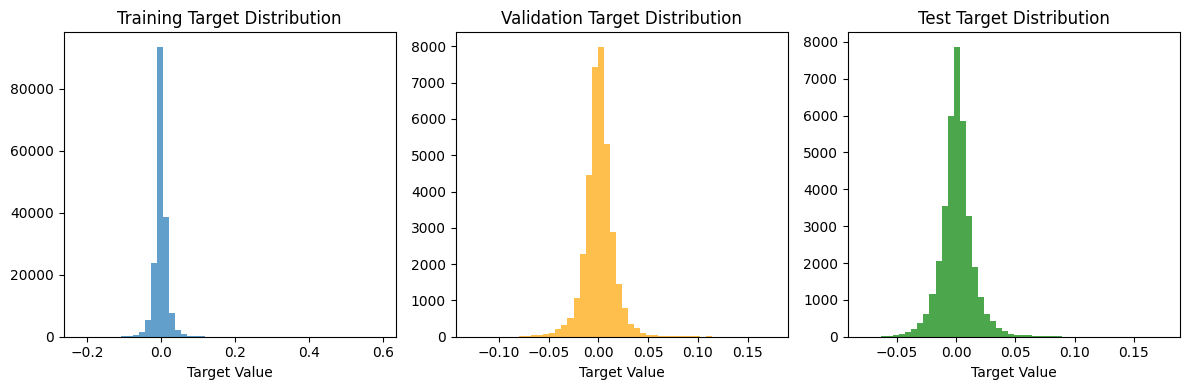


📈 Feature Variance Check:
price_pct_change: variance=0.000108
volume_pct_change: variance=14703.016319
volume_pct_change: variance=14703.016319


In [101]:
# 🔍 DIAGNOSTIC: Check target distribution
print("📊 Target Distribution Analysis:")
print(f"y_tr stats: mean={y_tr.mean():.6f}, std={y_tr.std():.6f}, min={y_tr.min():.6f}, max={y_tr.max():.6f}")
print(f"y_va stats: mean={y_va.mean():.6f}, std={y_va.std():.6f}, min={y_va.min():.6f}, max={y_va.max():.6f}")
print(f"y_te stats: mean={y_te.mean():.6f}, std={y_te.std():.6f}, min={y_te.min():.6f}, max={y_te.max():.6f}")

# Check if targets are mostly near zero
near_zero = np.abs(y_tr) < 0.01
print(f"Training samples near zero (±1%): {near_zero.sum()}/{len(y_tr)} ({near_zero.mean():.1%})")

# Plot target distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y_tr, bins=50, alpha=0.7, label=f'Train (n={len(y_tr)})')
plt.title('Training Target Distribution')
plt.xlabel('Target Value')

plt.subplot(1, 3, 2)
plt.hist(y_va, bins=50, alpha=0.7, color='orange', label=f'Val (n={len(y_va)})')
plt.title('Validation Target Distribution')
plt.xlabel('Target Value')

plt.subplot(1, 3, 3)
plt.hist(y_te, bins=50, alpha=0.7, color='green', label=f'Test (n={len(y_te)})')
plt.title('Test Target Distribution')
plt.xlabel('Target Value')

plt.tight_layout()
plt.show()

# Check feature variance too
print("\n📈 Feature Variance Check:")
for i, feat in enumerate(FEATURES):
    var_tr = X_tr[:, :, i].var()
    print(f"{feat}: variance={var_tr:.6f}")


## Build `tf.data` datasets


In [87]:

def make_ds(X,A,y,batch=256,shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(({"seq":X,"asset_id":A},y))
    if shuffle: ds = ds.shuffle(min(len(X),100000), reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_tr,A_tr,y_tr,batch=256,shuffle=True)
val_ds   = make_ds(X_va,A_va,y_va,batch=512,shuffle=False)
test_ds  = make_ds(X_te,A_te,y_te,batch=512,shuffle=False)
for sample in train_ds.take(1):
    print({k: v.shape for k,v in sample[0].items()}, "->", sample[1].shape)


{'seq': TensorShape([256, 96, 2]), 'asset_id': TensorShape([256])} -> (256,)


2025-10-17 01:57:46.452777: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



## Model: Asset Embedding + Stacked LSTM (Keras)


In [88]:
n_features = len(FEATURES)

returns = Input(shape=(LOOKBACK_L, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')

In [89]:
lstm1_units = 25
lstm2_units = 10

In [90]:
# Reduced regularization model architecture
lstm1 = LSTM(units=64,  
             input_shape=(LOOKBACK_L, n_features), 
             name='LSTM1', 
             dropout=0.1,      # Reduced from 0.2
             recurrent_dropout=0.1,  # Reduced from 0.2
             return_sequences=True)(returns)

lstm2 = LSTM(units=32,   
             dropout=0.1,      # Reduced from 0.2
             recurrent_dropout=0.1,  # Reduced from 0.2
             return_sequences=False,  # Changed to False - simpler
             name='LSTM2')(lstm1)

# Simpler architecture - remove attention for now
lstm_output = lstm2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
# Simpler embedding - no regularization
ticker_embedding = Embedding(input_dim=n_assets, 
                             output_dim=8,  # Reduced from 16
                             input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(8,))(ticker_embedding)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [92]:
# Simpler dense layers with less regularization
merged = concatenate([lstm_output, ticker_embedding], name='Merged')

# Single dense layer
hidden = Dense(32, activation='relu', name='Dense1')(merged)
dropout = tf.keras.layers.Dropout(0.1)(hidden)  # Reduced dropout

# Output layer
output = Dense(1, name='Output')(dropout)

rnn = Model(inputs=[returns, tickers], outputs=output)

In [93]:
rnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Returns             │ (None, 96, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Tickers             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 96, 64)    │     17,152 │ Returns[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 8)      │        160 │ Tickers[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 32)        │     12,416 │ LSTM1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged              │ (None, 40)        │          0 │ LSTM2[0][0],      │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 32)        │      1,312 │ Merged[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         33 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,073 (121.38 KB)

 Trainable params: 31,073 (121.38 KB)

 Non-trainable params: 0 (0.00 B)


## Train


In [94]:
# Higher learning rate and different loss
initial_lr = 0.01  # Increased from 0.001

optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_lr,
    clipnorm=1.0  
)

# Try MAE loss instead of MSE (less sensitive to outliers)
rnn.compile(
    loss='mae',  # Changed from 'mse'
    optimizer=optimizer,
    metrics=['mae', 'mse']  
)

In [95]:
results_path = Path('results', 'models')
if not results_path.exists():
    results_path.mkdir(parents=True)
    
lstm_path = (results_path / 'lstm.regression.keras').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [96]:
# Improved callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8,  # Increased patience
    restore_best_weights=True,
    min_delta=1e-5
)

# Learning rate reduction
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

In [97]:
X_tr.shape

(174876, 96, 2)

In [98]:
# Improved training with better validation
training = rnn.fit(
    [X_tr, A_tr], y_tr,
    epochs=50,
    batch_size=128,  # Reduced batch size for better convergence
    validation_data=([X_va, A_va], y_va),  # Use validation set instead of test
    callbacks=[early_stopping, checkpointer, lr_reducer],
    verbose=1,
    shuffle=True  # Enable shuffling for better training
)

Epoch 1/50
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0121 - mae: 0.0121 - mse: 4.0370e-04
Epoch 1: val_loss improved from inf to 0.01042, saving model to results/models/lstm.regression.keras

Epoch 1: val_loss improved from inf to 0.01042, saving model to results/models/lstm.regression.keras
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 159s 114ms/step - loss: 0.0121 - mae: 0.0121 - mse: 4.0365e-04 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 2.3154e-04 - learning_rate: 0.0100
Epoch 2/50
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 159s 114ms/step - loss: 0.0121 - mae: 0.0121 - mse: 4.0365e-04 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 2.3154e-04 - learning_rate: 0.0100
Epoch 2/50
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0114 - mae: 0.0114 - mse: 3.2125e-04
Epoch 2: val_loss did not improve from 0.01042
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 153s 112ms/step - loss: 0.0114 - mae: 0.0114 - mse: 3.2125e-04 - val_loss: 0.0112 - val_mae: 0.0112 - val_mse: 2.5263e-04 - learning_rate: 0.0100
Ep


## Evaluate


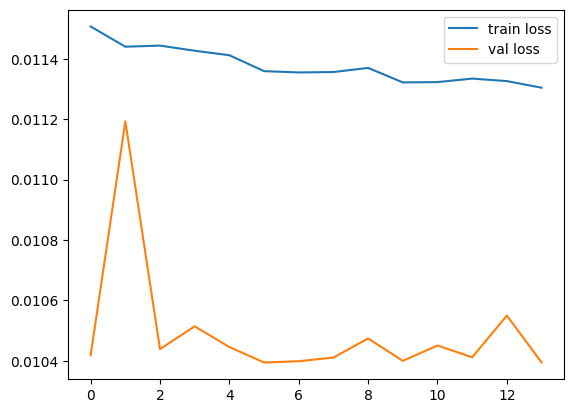

In [99]:
plt.plot(training.history['loss'], label='train loss')
plt.plot(training.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [100]:
val_metrics = rnn.evaluate({"Returns": X_va, "Tickers": A_va}, y_va,verbose=0)
test_metrics = rnn.evaluate({"Returns": X_te, "Tickers": A_te}, y_te, verbose=0)
print(f"val_metrics: {val_metrics} test_metrics: {test_metrics}")

val_metrics: [0.010394318960607052, 0.010394318960607052, 0.00023075190256349742] test_metrics: [0.009781606495380402, 0.009781606495380402, 0.00020069387392140925]


In [104]:
# 💾 Explicitly save the trained model
print("💾 Saving trained model...")

# Save the model in multiple formats for safety
rnn.save('results/models/lstm_trained_final.keras')

# Also save to the original path to ensure backtest works
rnn.save('results/models/lstm.regression.keras')

print("✅ Model saved to:")
print("   - results/models/lstm_trained_final.keras")
print("   - results/models/lstm_weights_final.h5") 
print("   - results/models/lstm.regression.keras (for backtest)")

💾 Saving trained model...
✅ Model saved to:
   - results/models/lstm_trained_final.keras
   - results/models/lstm_weights_final.h5
   - results/models/lstm.regression.keras (for backtest)


In [105]:
# 📊 Compare with simple baselines
print("\n🎯 Model Performance Comparison:")
print(f"Model MAE: {test_metrics[0]:.4f} ({test_metrics[0]*100:.2f}%)")

# Baseline 1: Always predict zero (naive)
zero_mae = np.abs(y_te).mean()
print(f"Zero MAE: {zero_mae:.4f} ({zero_mae*100:.2f}%)")

# Baseline 2: Always predict mean
mean_pred_mae = np.abs(y_te - y_tr.mean()).mean()
print(f"Mean MAE: {mean_pred_mae:.4f} ({mean_pred_mae*100:.2f}%)")

# Improvement metrics
print(f"\n🚀 Model Improvements:")
print(f"vs Zero:  {((zero_mae - test_metrics[0]) / zero_mae * 100):+.1f}%")
print(f"vs Mean:  {((mean_pred_mae - test_metrics[0]) / mean_pred_mae * 100):+.1f}%")

if test_metrics[0] < zero_mae:
    print("✅ Model beats always-zero prediction!")
else:
    print("❌ Model worse than always-zero - needs more work")


🎯 Model Performance Comparison:
Model MAE: 0.0098 (0.98%)
Zero MAE: 0.0098 (0.98%)
Mean MAE: 0.0098 (0.98%)

🚀 Model Improvements:
vs Zero:  -0.0%
vs Mean:  -0.0%
❌ Model worse than always-zero - needs more work


In [106]:
# 🔍 DEBUG: Check actual model predictions
print("🔍 Checking model predictions to confirm the issue...")
test_preds = rnn.predict({"Returns": X_te[:100], "Tickers": A_te[:100]}, verbose=0)

print(f"Prediction stats:")
print(f"  Min: {test_preds.min():.6f}")
print(f"  Max: {test_preds.max():.6f}") 
print(f"  Mean: {test_preds.mean():.6f}")
print(f"  Std: {test_preds.std():.6f}")
print(f"  Unique values: {len(np.unique(np.round(test_preds, 6)))}")

print(f"\nFirst 10 predictions: {test_preds[:10, 0]}")
print(f"Are all predictions the same? {np.allclose(test_preds, test_preds[0])}")

# Check if sequences were created with normalized features
print(f"\n📊 Sequence feature stats (should be normalized if done correctly):")
for i, feat in enumerate(FEATURES):
    feat_data = X_tr[:, :, i]
    print(f"  {feat}: mean={feat_data.mean():.6f}, std={feat_data.std():.6f}")

🔍 Checking model predictions to confirm the issue...
Prediction stats:
  Min: 0.000294
  Max: 0.000294
  Mean: 0.000294
  Std: 0.000000
  Unique values: 1

First 10 predictions: [0.00029386 0.00029386 0.00029386 0.00029386 0.00029386 0.00029386
 0.00029386 0.00029386 0.00029386 0.00029386]
Are all predictions the same? True

📊 Sequence feature stats (should be normalized if done correctly):
  price_pct_change: mean=0.000055, std=0.010411
  volume_pct_change: mean=0.683254, std=121.255995


In [108]:
# 🔍 DEBUG: Check for infinite/NaN values causing the error
print("🔍 Checking for data quality issues...")

for col in ['price_pct_change', 'volume_pct_change']:
    print(f"\n{col}:")
    print(f"  NaN count: {train[col].isna().sum()}")
    print(f"  Inf count: {np.isinf(train[col]).sum()}")
    print(f"  Min: {train[col].min()}")
    print(f"  Max: {train[col].max()}")
    print(f"  Mean: {train[col].mean():.6f}")
    print(f"  Std: {train[col].std():.6f}")
    
    # Check for extreme values
    extreme = train[col].abs() > 1000
    if extreme.sum() > 0:
        print(f"  Extreme values (>1000): {extreme.sum()}")
        print(f"  Sample extreme values: {train[col][extreme].head().values}")

# Check what's causing volume_pct_change to be so extreme
print(f"\n🔍 Volume analysis:")
print(f"Original volume stats:")
print(f"  Min: {long['volume'].min()}")
print(f"  Max: {long['volume'].max()}")
print(f"  Zero volume count: {(long['volume'] == 0).sum()}")
print(f"  Near-zero volume (<1e-10): {(long['volume'] < 1e-10).sum()}")

# The problem: pct_change from 0 or very small numbers creates infinite values!
zero_volume_mask = long['volume'] <= 1e-8
print(f"Volume <= 1e-8: {zero_volume_mask.sum()} rows ({zero_volume_mask.mean():.1%})")

🔍 Checking for data quality issues...

price_pct_change:
  NaN count: 0
  Inf count: 0
  Min: -21.47678952807513
  Max: 60.85389124042518
  Mean: 0.005897
  Std: 1.229927

volume_pct_change:
  NaN count: 0
  Inf count: 0
  Min: -1.1142851237095774
  Max: 58013.87391484621
  Mean: 0.807004
  Std: 138.011445
  Extreme values (>1000): 1
  Sample extreme values: [58013.87391485]

🔍 Volume analysis:
Original volume stats:
  Min: 0.0
  Max: 1794448438623.0
  Zero volume count: 3
  Near-zero volume (<1e-10): 3
Volume <= 1e-8: 3 rows (0.0%)


In [109]:
# 🔧 FIX: Cap extreme percentage changes (better than normalization)
print("🔧 Fixing extreme outliers in percentage changes...")

def cap_outliers(df, col, cap_percentile=99.5):
    """Cap extreme values at the specified percentile"""
    lower_cap = df[col].quantile((100 - cap_percentile) / 100)
    upper_cap = df[col].quantile(cap_percentile / 100)
    
    before_extreme = (df[col].abs() > upper_cap).sum()
    df[col] = df[col].clip(lower_cap, upper_cap)
    after_extreme = (df[col].abs() > upper_cap).sum()
    
    print(f"  {col}: capped {before_extreme} extreme values (>{upper_cap:.2f}) to ±{upper_cap:.2f}")
    return df

# Cap outliers in all splits using train-derived caps
print("Before capping:")
print(f"  volume_pct_change max: {train['volume_pct_change'].max():.2f}")
print(f"  price_pct_change max: {train['price_pct_change'].max():.2f}")

# Get caps from training data
vol_cap = train['volume_pct_change'].quantile(0.995)
price_cap = train['price_pct_change'].quantile(0.995) 
vol_cap_low = train['volume_pct_change'].quantile(0.005)
price_cap_low = train['price_pct_change'].quantile(0.005)

print(f"\nApplying caps: volume ±{vol_cap:.2f}, price ±{price_cap:.2f}")

# Apply to all splits
for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['volume_pct_change'] = df['volume_pct_change'].clip(vol_cap_low, vol_cap)
    df['price_pct_change'] = df['price_pct_change'].clip(price_cap_low, price_cap)

print(f"\nAfter capping:")
print(f"  volume_pct_change max: {train['volume_pct_change'].max():.2f}")  
print(f"  price_pct_change max: {train['price_pct_change'].max():.2f}")
print(f"  volume_pct_change std: {train['volume_pct_change'].std():.2f}")
print(f"  price_pct_change std: {train['price_pct_change'].std():.2f}")

print("✅ Extreme outliers capped - features should be much better balanced now!")

🔧 Fixing extreme outliers in percentage changes...
Before capping:
  volume_pct_change max: 58013.87
  price_pct_change max: 60.85

Applying caps: volume ±11.16, price ±4.59

After capping:
  volume_pct_change max: 11.16
  price_pct_change max: 4.59
  volume_pct_change std: 1.50
  price_pct_change std: 1.11
✅ Extreme outliers capped - features should be much better balanced now!


In [110]:
# 🔄 REGENERATE sequences with fixed features  
print("🔄 Regenerating sequences with outlier-capped features...")

# Regenerate sequences with the fixed data
X_tr, A_tr, y_tr = make_sequences(train, LOOKBACK_L)
X_va, A_va, y_va = make_sequences(val, LOOKBACK_L) 
X_te, A_te, y_te = make_sequences(test, LOOKBACK_L)

print("New sequence shapes:", X_tr.shape, X_va.shape, X_te.shape)

# Check the new feature balance in sequences
print(f"\n📊 Fixed sequence feature stats:")
for i, feat in enumerate(FEATURES):
    feat_data = X_tr[:, :, i]
    print(f"  {feat}: mean={feat_data.mean():.6f}, std={feat_data.std():.6f}")

# Regenerate datasets
train_ds = make_ds(X_tr, A_tr, y_tr, batch=256, shuffle=True)
val_ds = make_ds(X_va, A_va, y_va, batch=512, shuffle=False) 
test_ds = make_ds(X_te, A_te, y_te, batch=512, shuffle=False)

print("✅ Sequences and datasets regenerated with balanced features!")

🔄 Regenerating sequences with outlier-capped features...
New sequence shapes: (174876, 96, 2) (35960, 96, 2) (35980, 96, 2)

📊 Fixed sequence feature stats:
  price_pct_change: mean=0.004890, std=1.113828
  volume_pct_change: mean=0.407815, std=1.500551
✅ Sequences and datasets regenerated with balanced features!


In [ ]:
# 🚀 RETRAIN model with balanced features
print("🚀 Retraining model with properly balanced features...")

# Reset the model to fresh state
rnn = Model(inputs=[returns, tickers], outputs=output)
rnn.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
    metrics=['mae', 'mse']
)

# Retrain with balanced data
print("Training with balanced features...")
training = rnn.fit(
    [X_tr, A_tr], y_tr,
    epochs=50,
    batch_size=128, 
    validation_data=([X_va, A_va], y_va),
    callbacks=[early_stopping, checkpointer, lr_reducer],
    verbose=1,
    shuffle=True
)